In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
import math
import glob
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mapping for special ticker cases
TICKER_MAPPING = {
    'BRK': 'BRK-B',
    'AAPL': 'AAPL',
    'XOM': 'XOM',
    'F': 'F',
    'MUR': 'MUR'
}

In [7]:
def get_market_data(ticker_symbol):
    """
    Get market data from yfinance for a given ticker.
    
    Parameters:
    -----------
    ticker_symbol : str
        Stock ticker symbol
        
    Returns:
    --------
    dict: Market data including market cap, total debt, and beta
    """
    # Map ticker to correct yfinance symbol
    yf_ticker = TICKER_MAPPING.get(ticker_symbol, ticker_symbol)
    ticker = yf.Ticker(yf_ticker)
    
    try:
        info = ticker.info
    except:
        print(f"Error fetching info for {yf_ticker}")
        return {
            'market_cap': 0,
            'total_debt': 0,
            'beta': 1,
            'asset_value': 0
        }
    
    market_data = {
        'market_cap': info.get('marketCap', 0),
        'total_debt': info.get('totalDebt', 0),
        'beta': info.get('beta', 1),
        'asset_value': info.get('marketCap', 0) + info.get('totalDebt', 0)
    }
    
    return market_data

def load_bond_data():
    """
    Load bond data from Excel files in the current directory.
    
    Returns:
    --------
    dict: Dictionary of DataFrames containing bond data
    """
    bond_data = {}
    excel_files = glob.glob('*.xlsx')
    
    for file in excel_files:
        ticker = file.split()[0]
        df = pd.read_excel(file)
        df.columns = df.columns.str.strip().str.replace('\n', ' ')
        
        #Add to dictionary
        bond_data[ticker] = df
        
    return bond_data

In [8]:
def distance_to_default(stock, T):
    """
    Calculate distance to default using balance sheet and market data.
    
    Parameters:
    -----------
    stock : str
        Stock ticker symbol
    T : float
        Time horizon in years
        
    Returns:
    --------
    float: Distance to default
    """
    try:
        # Map ticker to correct yfinance symbol
        yf_ticker = TICKER_MAPPING.get(stock, stock)
        ticker = yf.Ticker(yf_ticker)
        
        # Get balance sheet data
        bs = ticker.balance_sheet
        if bs.empty:
            raise ValueError("No balance sheet data available")
            
        # Get the most recent balance sheet data
        latest_bs = bs.iloc[:, 0]  # Most recent quarter
        
        # Try different possible column names for debt
        if 'Total Debt' in latest_bs.index:
            debt = latest_bs['Total Debt']
        elif 'Long Term Debt' in latest_bs.index:
            debt = latest_bs['Long Term Debt']
        elif 'Current Debt' in latest_bs.index:
            debt = latest_bs['Current Debt']
        else:
            # If no debt information found, use market data
            market_data = get_market_data(stock)
            debt = market_data['total_debt']
        
        # Get assets and equity
        if 'Total Assets' in latest_bs.index:
            assets = latest_bs['Total Assets']
        elif 'Current Assets' in latest_bs.index:
            assets = latest_bs['Current Assets']
        else:
            market_data = get_market_data(stock)
            assets = market_data['asset_value']
            
        if 'Total Stockholder Equity' in latest_bs.index:
            equity = latest_bs['Total Stockholder Equity']
        elif 'Stockholders Equity' in latest_bs.index:
            equity = latest_bs['Stockholders Equity']
        else:
            market_data = get_market_data(stock)
            equity = market_data['market_cap']
        
        # Ensure we have positive values
        if debt <= 0 or assets <= 0 or equity <= 0:
            market_data = get_market_data(stock)
            debt = max(debt, market_data['total_debt'])
            assets = max(assets, market_data['asset_value'])
            equity = max(equity, market_data['market_cap'])
        
        # Calculate asset-to-equity ratio
        a_to_e_ratio = assets / equity if equity != 0 else 1
        
        # Calculate volatilities
        stock_data = yf.download(yf_ticker, period='1y')['Adj Close']
        sige = np.std(stock_data.pct_change().dropna()) * np.sqrt(252)
        siga = sige * np.sqrt(a_to_e_ratio)
        
        # Get risk-free rate
        try:
            r = yf.download('^IRX', period='1d')['Adj Close'][-1] / 100
        except:
            r = 0.0425  # Default to 4.25% if unable to fetch
        
        # Calculate distance to default
        dd = (np.log(assets / debt) - (r - siga**2/2) * T) / (siga * np.sqrt(T))
        
        return dd
        
    except Exception as e:
        print(f"Error calculating distance to default for {stock}: {str(e)}")
        return None


def probability_of_default(stock, T):
    dd = distance_to_default(stock, T)
    if dd is not None:
        return norm.cdf(-dd)
    return None


In [9]:
def prepare_model_data():
    """
    Prepare data for the one-factor model using probability of default.
    
    Returns:
    --------
    tuple: (X, y) feature matrix and target variable
    """
    bond_data = load_bond_data()
    
    X = []  # Features (probability of default)
    y = []  # Target (credit spreads)
    
    for ticker, df in bond_data.items():
        try:
            print(f"Processing {ticker}...")
            
            # Calculate probability of default for the company
            pd_value = probability_of_default(ticker, T=5)  # 5-year time horizon
            
            # Process each observation
            for _, row in df.iterrows():
                try:
                    # Get credit spread from bond data
                    if 'Bid OAS Spread (bp)  (R2)' in row:
                        spread = float(row['Bid OAS Spread (bp)  (R2)'])
                    elif 'Bid OAS Spread (bp) (R2)' in row:
                        spread = float(row['Bid OAS Spread (bp) (R2)'])
                    else:
                        continue

                    if pd.isna(spread):
                        continue
                    
                    # Add to dataset if valid
                    if pd_value is not None and not pd.isna(pd_value):
                        X.append([pd_value])
                        y.append(spread)
                
                except (ValueError, TypeError) as e:
                    continue  # Skip rows with conversion errors
                
        except Exception as e:
            print(f"Error processing {ticker}: {str(e)}")
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Final check for empty arrays
    if len(X) == 0 or len(y) == 0:
        raise ValueError("No valid data points found after cleaning")
    
    print(f"Final dataset size: {len(X)} observations")
    return X, y

In [10]:
def build_factor_model(X, y):
    """
    Build and evaluate a one-factor model for credit spreads.
    
    Parameters:
    -----------
    X : array-like
        Feature matrix (probability of default)
    y : array-like
        Credit spreads
        
    Returns:
    --------
    dict: Model results and metrics
    """
    # Additional data validation
    if len(X) < 2 or len(y) < 2:
        raise ValueError("Not enough data points for model building")
    
    # Remove any remaining NaN values
    mask = ~np.isnan(y)
    X = X[mask]
    y = y[mask]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    # Create coefficient information
    coefficients = pd.DataFrame({
        'Feature': ['Probability of Default'],
        'Coefficient': [model.coef_[0]]
    })
    
    return {
        'model': model,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'coefficients': coefficients,
        'y_test': y_test,
        'y_pred_test': y_pred_test,
        'intercept': model.intercept_
    }

In [11]:

def plot_results(results):
    """
    Plot the model results.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing model results
    """
    plt.figure(figsize=(15, 5))
    
    # Actual vs Predicted Plot
    plt.subplot(1, 2, 1)
    plt.scatter(results['y_test'], results['y_pred_test'], alpha=0.5)
    plt.plot([results['y_test'].min(), results['y_test'].max()], 
             [results['y_test'].min(), results['y_test'].max()], 
             'r--', lw=2)
    plt.xlabel('Actual Credit Spread (bps)')
    plt.ylabel('Predicted Credit Spread (bps)')
    plt.title('Actual vs Predicted Credit Spreads')
    
    # Model Equation Plot
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.5, 
             f'Credit Spread = {results["coefficients"]["Coefficient"].iloc[0]:.2f} × PD + {results["intercept"]:.2f}',
             fontsize=12)
    plt.axis('off')
    plt.title('One-Factor Model Equation')
    
    plt.tight_layout()
    
    # Residual Plot
    plt.figure(figsize=(10, 5))
    residuals = results['y_test'] - results['y_pred_test']
    plt.scatter(results['y_pred_test'], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Credit Spread (bps)')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.tight_layout()


Loading and preparing data...
Processing XOM...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing F...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing AAPL...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing MUR...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing BRK...
Error calculating distance to default for BRK: single positional indexer is out-of-bounds
Final dataset size: 744 observations
Shape of feature matrix X: (744, 1)
Shape of target variable y: (744,)

Building one-factor model...

One-Factor Model Results:
Training MSE: 4460.32
Testing MSE: 4142.74
Training R²: 0.282
Testing R²: 0.243

Model Equation:
Credit Spread = -23743.85 × PD + 119.40


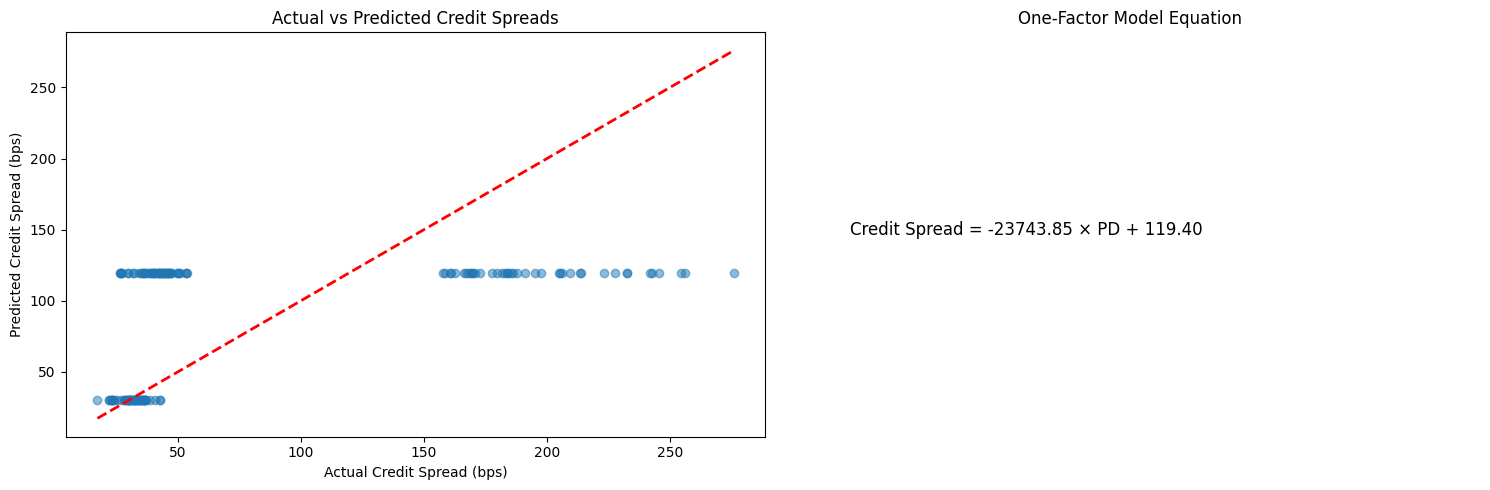

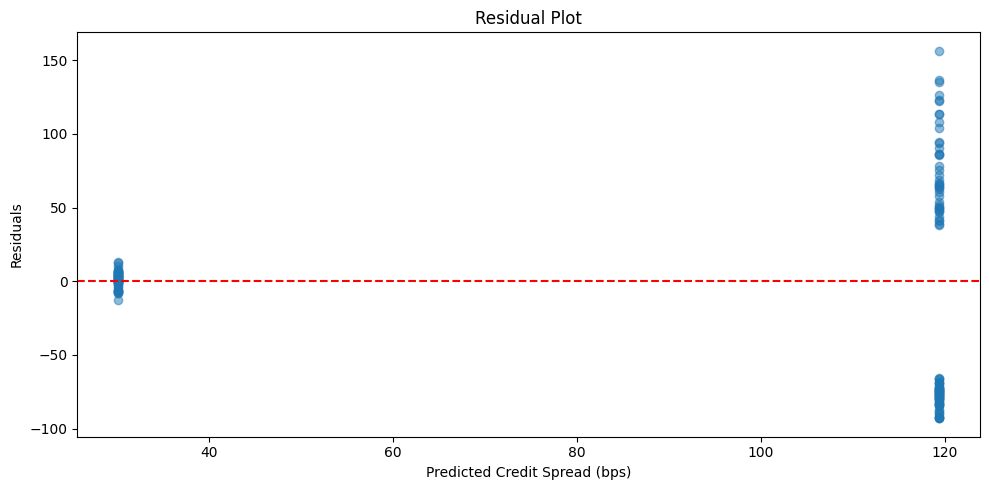

In [12]:
if __name__ == "__main__":
    # Prepare data
    print("Loading and preparing data...")
    X, y = prepare_model_data()
    print(f"Shape of feature matrix X: {X.shape}")
    print(f"Shape of target variable y: {y.shape}")
    
    # Build and evaluate the model
    print("\nBuilding one-factor model...")
    results = build_factor_model(X, y)
    
    # Print results
    print("\nOne-Factor Model Results:")
    print(f"Training MSE: {results['train_mse']:.2f}")
    print(f"Testing MSE: {results['test_mse']:.2f}")
    print(f"Training R²: {results['train_r2']:.3f}")
    print(f"Testing R²: {results['test_r2']:.3f}")
    
    print("\nModel Equation:")
    print(f"Credit Spread = {results['coefficients']['Coefficient'].iloc[0]:.2f} × PD + {results['intercept']:.2f}")
    
    # Plot results
    plot_results(results)
    plt.show() 